# A simple pipeline of HEP Analytics

## Instructions
- for jupyter-notebook: `export PYSPARK_DRIVER_PYTHON=jupyter-notebook`
- for a specific conf, adapt: `export PYSPARK_DRIVER_PYTHON_OPTS="--ip=`hostname` --browser='/dev/null' --port=8888"`
- launch: `pyspark --packages org.diana-hep:spark-root_2.11:0.1.16`
- that should be it!

## Input
- 3 types (diferent physics) of identical schema sets of input files

## Notes
I have been observing the following exception with Apache Spark 2.3 
```
  File "/Users/vk/software/sparks/spark-2.3.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/daemon.py", line 157, in manager
  File "/Users/vk/software/sparks/spark-2.3.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/daemon.py", line 61, in worker
  File "/Users/vk/software/sparks/spark-2.3.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 254, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/Users/vk/software/sparks/spark-2.3.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/serializers.py", line 685, in read_int
    raise EOFError
```

## Step 1

In [1]:
df_qcd = sqlContext.read.format("org.dianahep.sparkroot.experimental").load("file:/Users/vk/data/ML_MP_JR/test_local/qcd*.root")

In [2]:
df_ttbar = sqlContext.read.format("org.dianahep.sparkroot.experimental").load("file:/Users/vk/data/ML_MP_JR/test_local/ttbar*.root")

In [3]:
df_wjets = sqlContext.read.format("org.dianahep.sparkroot.experimental").load("file:/Users/vk/data/ML_MP_JR/test_local/wjets*.root")

In [4]:
from pyspark.sql.functions import lit

label_qcd = 0
label_ttbar = 1
label_wjets = 2

df_all = df_qcd.withColumn("label", lit(label_qcd))\
    .union(df_ttbar.withColumn("label", lit(label_ttbar)))\
    .union(df_wjets.withColumn("label", lit(label_wjets)))

In [5]:
df_all.printSchema()

root
 |-- Event: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- fUniqueID: integer (nullable = true)
 |    |    |-- fBits: integer (nullable = true)
 |    |    |-- Number: long (nullable = true)
 |    |    |-- ReadTime: float (nullable = true)
 |    |    |-- ProcTime: float (nullable = true)
 |    |    |-- ProcessID: integer (nullable = true)
 |    |    |-- MPI: integer (nullable = true)
 |    |    |-- Weight: float (nullable = true)
 |    |    |-- Scale: float (nullable = true)
 |    |    |-- AlphaQED: float (nullable = true)
 |    |    |-- AlphaQCD: float (nullable = true)
 |    |    |-- ID1: integer (nullable = true)
 |    |    |-- ID2: integer (nullable = true)
 |    |    |-- X1: float (nullable = true)
 |    |    |-- X2: float (nullable = true)
 |    |    |-- ScalePDF: float (nullable = true)
 |    |    |-- PDF1: float (nullable = true)
 |    |    |-- PDF2: float (nullable = true)
 |-- Event_size: integer (nullable = true)
 |-- Particle: arr

In [6]:
requiredColumns = ["EFlowTrack", "MuonTight_size", "Electron_size", "EFlowNeutralHadron", "EFlowPhoton", "Electron", "MuonTight", "MissingET", "Jet", "label"]
events = df_all.select(requiredColumns).toDF(*requiredColumns)

In [7]:
import numpy as np
import math
import time
from pyspark.sql import Row

In [8]:
def PFIso(p, DR, PtMap, subtractPt):
    if p.Pt() <= 0.: return 0.
    DeltaEta = PtMap[:,0] - p.Eta()
    DeltaPhi = PtMap[:,1] - p.Phi()
    twopi = 2.*3.1415
    DeltaPhi = DeltaPhi - twopi*(DeltaPhi >  twopi) + twopi*(DeltaPhi < -1.*twopi)
    isInCone = DeltaPhi*DeltaPhi + DeltaEta*DeltaEta < DR*DR
    Iso = PtMap[isInCone, 2].sum()/p.Pt()
    if subtractPt: Iso = Iso -1
    return float(Iso)

# get the selected tracks
def ChPtMapp(DR, event):
    pTmap = []
    for h in event.EFlowTrack:
        if h.PT<= 0.5: continue
        pTmap.append([h.Eta, h.Phi, h.PT])
        #nParticles += 1
    #pTmap = np.reshape(pTmap, (nParticles, 3))
    return np.asarray(pTmap)

# get the selected neutrals
def NeuPtMapp(DR, event):
    pTmap = []
    #nParticles = 0
    for h in event.EFlowNeutralHadron:
        if h.ET<= 1.0: continue
        pTmap.append([h.Eta, h.Phi, h.ET])
        #nParticles += 1
    #pTmap = np.reshape(pTmap, (nParticles, 3))
    return np.asarray(pTmap)

# get the selected photons
def PhotonPtMapp(DR, event):
    pTmap = []
    #nParticles = 0
    for h in event.EFlowPhoton:
        if h.ET<= 1.0: continue
        pTmap.append([h.Eta, h.Phi, h.ET])
        #nParticles += 1
    #pTmap = np.reshape(pTmap, (nParticles, 3))
    return np.asarray(pTmap)

def Phi_mpi_pi(x):
    while x >= 3.1415: 
        x -= 2*3.1415
    while x < -3.1415:
        x += 2*3.1415
    return x

class LorentzVector(object):
    def __init__(self, *args):
        if len(args)>0:
            self.x = args[0]
            self.y = args[1]
            self.z = args[2]
            self.t = args[3]
    
    def SetPtEtaPhiM(self, pt, eta, phi, mass):
        pt = abs(pt)
        self.SetXYZM(pt*math.cos(phi), pt*math.sin(phi), pt*math.sinh(eta), mass)
        
    def SetXYZM(self, x, y, z, m):
        self.x = x;
        self.y = y
        self.z = z
        if (m>=0):
            self.t = math.sqrt(x*x + y*y + z*z + m*m)
        else:
            self.t = math.sqrt(max(x*x + y*y + z*z - m*m, 0))
            
    def E(self):
        return self.t
    
    def Px(self): 
        return self.x
    
    def Py(self):
        return self.y
    
    def Pz(self):
        return self.z
    
    def Pt(self):
        return math.sqrt(self.x*self.x + self.y*self.y)
    
    def Eta(self):
        cosTheta = self.CosTheta()
        if cosTheta*cosTheta<1:
            return -0.5*math.log((1.0 - cosTheta)/(1.0 + cosTheta))
        if self.z == 0: return 0
    
    def mag(self):
        return math.sqrt(self.x*self.x + self.y*self.y + self.z*self.z)
    
    def CosTheta(self):
        return 1.0 if self.mag()==0.0 else self.z/self.mag()
    
    def Phi(self):
        return math.atan2(self.y, self.x)
    
    def DeltaR(self, other):
        deta = self.Eta() - other.Eta()
        dphi = Phi_mpi_pi(self.Phi() - other.Phi())
        return math.sqrt(deta*deta + dphi*dphi)
    
def mysign_func(v):
    if v<0: return -1.
    elif v==0: return 0.
    else: return 1.

In [9]:
def selection(event, TrkPtMap, NeuPtMap, PhotonPtMap):
    # one electron or muon with pT> 15 GeV
    if event.Electron_size == 0 and event.MuonTight_size == 0: return False, False, False
    foundMuon = None #[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0, 0, 0, 0, 1, 1]
    foundEle =  None #[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0, 0, 0, 1, 0, 1]
    
    #
    # Has to replace the TLorentzVector functionality
    #
    l = LorentzVector()
    for ele in event.Electron:
        if ele.PT <= 25.: continue
        #
        # Has to replace the TLorentzVector functionality
        #
        l.SetPtEtaPhiM(ele.PT, ele.Eta, ele.Phi, 0.)
        
        pfisoCh = PFIso(l, 0.3, TrkPtMap, True)
        pfisoNeu = PFIso(l, 0.3, NeuPtMap, False)
        pfisoGamma = PFIso(l, 0.3, PhotonPtMap, False)
        if foundEle == None and (pfisoCh+pfisoNeu+pfisoGamma)<0.2:
            #foundEle.SetPtEtaPhiM(ele.PT, ele.Eta, ele.Phi, 0.)
            foundEle = [l.E(), l.Px(), l.Py(), l.Pz(), l.Pt(), l.Eta(), l.Phi(), 0., 0., 0., pfisoCh, pfisoGamma, pfisoNeu, 0., 0., 0., 1., 0., float(ele.Charge)]
    for muon in event.MuonTight:
        if muon.PT <= 25.: continue
        #
        # Has to replace the TLorentzVector functionality
        #
        l.SetPtEtaPhiM(muon.PT, muon.Eta, muon.Phi, 0.)
        
        pfisoCh = PFIso(l, 0.3, TrkPtMap, True)
        pfisoNeu = PFIso(l, 0.3, NeuPtMap, False)
        pfisoGamma = PFIso(l, 0.3, PhotonPtMap, False)
        if foundMuon == None and (pfisoCh+pfisoNeu+pfisoGamma)<0.2:
            foundMuon = [l.E(), l.Px(), l.Py(), l.Pz(), l.Pt(), l.Eta(), l.Phi(), 0., 0., 0., pfisoCh, pfisoGamma, pfisoNeu, 0., 0., 0., 0., 1., float(muon.Charge)]
    if foundEle != None and foundMuon != None:
        if foundEle[5] > foundMuon[5]:
            return True, foundEle, foundMuon
        else:
            return True, foundMuon, foundEle
    if foundEle != None: return True, foundEle, foundMuon
    if foundMuon != None: return True, foundMuon, foundEle
    return False, None, None

In [10]:
def convert(event):
    q = LorentzVector()
    particles = []
    TrkPtMap = ChPtMapp(0.3, event)
    NeuPtMap = NeuPtMapp(0.3, event)
    PhotonPtMap = PhotonPtMapp(0.3, event)
    if TrkPtMap.shape[0] == 0: return Row()
    if NeuPtMap.shape[0] == 0: return Row()
    if PhotonPtMap.shape[0] == 0: return Row()
    
    #
    # Get leptons
    #
    selected, lep, otherlep = selection(event, TrkPtMap, NeuPtMap, PhotonPtMap)
    if not selected: return Row()
    particles.append(lep)
    lepMomentum = LorentzVector(lep[1], lep[2], lep[3], lep[0])
    nTrk = 0
    
    #
    # Select Tracks
    #
    for h in event.EFlowTrack:
        if nTrk>=450: continue
        if h.PT<=0.5: continue
        q.SetPtEtaPhiM(h.PT, h.Eta, h.Phi, 0.)
        if lepMomentum.DeltaR(q) > 0.0001:
            pfisoCh = PFIso(q, 0.3, TrkPtMap, True)
            pfisoNeu = PFIso(q, 0.3, NeuPtMap, False)
            pfisoGamma = PFIso(q, 0.3, PhotonPtMap, False)
            particles.append([q.E(), q.Px(), q.Py(), q.Pz(), h.PT, h.Eta, h.Phi, h.X, h.Y, h.Z, pfisoCh, pfisoGamma, pfisoNeu, 1., 0., 0., 0., 0., mysign_func(h.PID)])
            nTrk += 1
    nPhoton = 0
    
    #
    # Select Photons
    #
    for h in event.EFlowPhoton:
        if nPhoton >= 150: continue
        if h.ET <= 1.: continue
        q.SetPtEtaPhiM(h.ET, h.Eta, h.Phi, 0.)
        pfisoCh = PFIso(q, 0.3, TrkPtMap, True)
        pfisoNeu = PFIso(q, 0.3, NeuPtMap, False)
        pfisoGamma = PFIso(q, 0.3, PhotonPtMap, False)
        particles.append([q.E(), q.Px(), q.Py(), q.Pz(), h.ET, h.Eta, h.Phi, 0., 0., 0., pfisoCh, pfisoGamma, pfisoNeu, 0., 0., 1., 0., 0., 0.])
        nPhoton += 1
    nNeu = 0
    
    #
    # Select Neutrals
    #
    for h in event.EFlowNeutralHadron:
        if nNeu >= 200: continue
        if h.ET <= 1.: continue
        q.SetPtEtaPhiM(h.ET, h.Eta, h.Phi, 0.)
        pfisoCh = PFIso(q, 0.3, TrkPtMap, True)
        pfisoNeu = PFIso(q, 0.3, NeuPtMap, False)
        pfisoGamma = PFIso(q, 0.3, PhotonPtMap, False)
        particles.append([q.E(), q.Px(), q.Py(), q.Pz(), h.ET, h.Eta, h.Phi, 0., 0., 0., pfisoCh, pfisoGamma, pfisoNeu, 0., 1., 0., 0., 0., 0.])
        nNeu += 1
    for iTrk in range(nTrk, 450):
        particles.append([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
    for iPhoton in range(nPhoton, 150):
        particles.append([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
    for iNeu in range(nNeu, 200):
        particles.append([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
        
    #
    # High Level Features
    #
    myMET = event.MissingET[0]
    MET = myMET.MET
    phiMET = myMET.Phi
    MT = 2.*MET*lepMomentum.Pt()*(1-math.cos(lepMomentum.Phi()-phiMET))
    HT = 0.
    nJets = 0.
    nBjets = 0.
    for jet in event.Jet:
        if jet.PT > 40 and abs(jet.Eta)<2.4:
            nJets += 1
            HT += jet.PT
            if jet.BTag>0: 
                nBjets += 1
    LepPt = lep[4]
    LepEta = lep[5]
    LepPhi = lep[6]
    LepIsoCh = lep[10]
    LepIsoGamma = lep[11]
    LepIsoNeu = lep[12]
    LepCharge = lep[18]
    LepIsEle = lep[16]
    hlf = [HT, MET, phiMET, MT, nJets, nBjets, LepPt, LepEta, LepPhi,
           LepIsoCh, LepIsoGamma, LepIsoNeu, LepCharge, LepIsEle]
        
    #
    # return the Row of low level features and high level features
    #
    return Row(lfeatures=particles, hfeatures=hlf, label=event.label)

In [11]:
before = time.time()
featured_df = events\
    .rdd\
    .map(convert)\
    .filter(lambda row: len(row) > 0)\
    .toDF()
after = time.time()
print("Total Processing Time: %d seconds" % int(after - before))

Total Processing Time: 7 seconds


In [12]:
featured_df.printSchema()

root
 |-- hfeatures: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- label: long (nullable = true)
 |-- lfeatures: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: double (containsNull = true)



In [13]:
featured_df.show()

+--------------------+-----+--------------------+
|           hfeatures|label|           lfeatures|
+--------------------+-----+--------------------+
|[0.0, 15.38244152...|    0|[[350.16712348848...|
|[0.0, 46.25644302...|    0|[[691.60135934507...|
|[0.0, 12.70011329...|    0|[[291.31190800012...|
|[0.0, 38.32612609...|    0|[[64.027014590621...|
|[0.0, 12.86221885...|    0|[[585.69267054859...|
|[0.0, 29.51152229...|    0|[[153.69146716728...|
|[0.0, 43.41433334...|    0|[[121.83299776008...|
|[0.0, 26.42994499...|    0|[[50.084052360119...|
|[45.5724678039550...|    0|[[56.209728531517...|
|[41.1624641418457...|    0|[[119.42542669201...|
|[0.0, 16.75757026...|    0|[[35.841779813841...|
|[0.0, 30.75767326...|    0|[[42.584001705137...|
|[0.0, 26.82678222...|    0|[[72.304994874126...|
|[129.508174896240...|    0|[[32.162579291711...|
|[58.4740600585937...|    0|[[395.52691091323...|
|[91.7738037109375...|    0|[[83.352819491660...|
|[0.0, 12.72016525...|    0|[[451.26164360727...|


In [14]:
#
# limit to just 10 rows, this is quite slow.... although i did not test out spark 2.3 with apache arrow in-memory...
# obviously we could feed this directly into the next step without storing to disk
# for the purpose of validation, i was flushing back to disk and then comparing
#
featured_df.limit(10).write.parquet("file:/tmp/test_step1", mode="overwrite")

## Step 2
- Produce the 2D images for training 
- Optionally can save to disk for comparison with the baseline

In [15]:
#
# from above or get it from disk
# again, i limit to just 10 rows, this is arbitrary
# 
features = featured_df.limit(10)

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time, os
from pyspark.sql import Row
from scipy import misc
from skimage import draw

In [17]:
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors, Matrices

In [18]:
feature_variables = ['Energy', 'Px', 'Py', 'Pz', 'Pt', 'Eta', 'Phi', 
                    'vtxX', 'vtxY', 'vtxZ','ChPFIso', 'GammaPFIso', 'NeuPFIso',
                    'isChHad', 'isNeuHad', 'isGamma', 'isEle',  'isMu', 
                        #'Charge'
           ]


# In[259]:

colors = {'isMu' : 'green',
        'isEle': 'green',
         'isGamma':'blue',
         'isChHad' : 'red',
         'isNeuHad': 'yellow'}

shapes = {'isMu' : 5,
          'isEle': 5,
          'isGamma':3,
          'isChHad' : 4,
          'isNeuHad': 0}

c_colors = [colors[k] for k in feature_variables[13:]]+['black']
cc_colors = [np.asarray(matplotlib.colors.to_rgb(k)) for k in c_colors]
cc_shapes = [shapes[k] for k in feature_variables[13:]]+[0]

print c_colors
print cc_colors
print cc_shapes

['red', 'yellow', 'blue', 'green', 'green', 'black']
[array([ 1.,  0.,  0.]), array([ 1.,  1.,  0.]), array([ 0.,  0.,  1.]), array([ 0.        ,  0.50196078,  0.        ]), array([ 0.        ,  0.50196078,  0.        ]), array([ 0.,  0.,  0.])]
[4, 0, 3, 5, 5, 0]


In [19]:
def showImage(image):
    fig = plt.figure(frameon=False)
    plt.imshow(image.swapaxes(0,1))
    plt.axis('off')
    plt.show()

def create3D(data):
    max_eta = 5
    max_phi = np.pi
    res= 100
    neta = int(max_eta*res)
    nphi = int(max_phi*res)
    eeta = 2.*max_eta / float(neta)
    ephi = 2.*max_phi / float(nphi)
    def ieta( eta ): return (eta+max_eta) / eeta
    def iphi(phi) : return (phi+max_phi) / ephi
    blend = 0.3
    image = np.ones((neta,nphi,3), dtype = np.float32)
    
    before_loop = time.time()
    for ip in range(data.shape[0]):
        p_data = data[ip,:]
        eta = p_data[0]
        phi = p_data[1]
        if eta==0 and phi==0: 
            #print ip
            continue
        #pT = p_data[2]
        #lpT = min(max(np.log(pT)/5.,0.001), 10)*res/2.
        lpT = p_data[2]
        ptype = int(p_data[3])
        c = cc_colors[ ptype ]
        s = cc_shapes[ ptype ]
        R = lpT * res/1.5
        iee = ieta(eta)
        ip0 = iphi(phi)
        ip1 = iphi(phi+2*np.pi)
        ip2 = iphi(phi-2*np.pi)
        
        if s==0:
            xi0,yi0 = draw.circle(  iee, ip0,radius=R, shape=image.shape[:2])
            xi1,yi1 = draw.circle( iee, ip1, radius=R, shape=image.shape[:2])
            xi2,yi2 = draw.circle( iee, ip2, radius=R, shape=image.shape[:2]) 
            #if ptype == 5:
            #    print "MET",eta,phi
        else:
            nv = s
            vx = [iee + R*np.cos(ang) for ang in np.arange(0,2*np.pi, 2*np.pi/nv)]
            vy = [ip0 + R*np.sin(ang) for ang in np.arange(0,2*np.pi, 2*np.pi/nv)]
            vy1 = [ip1 + R*np.sin(ang) for ang in np.arange(0,2*np.pi, 2*np.pi/nv)]
            vy2 = [ip2 + R*np.sin(ang) for ang in np.arange(0,2*np.pi, 2*np.pi/nv)]
            xi0,yi0 = draw.polygon( vx, vy , shape=image.shape[:2])
            xi1,yi1 = draw.polygon( vx, vy1 , shape=image.shape[:2])
            xi2,yi2 = draw.polygon( vx, vy2 , shape=image.shape[:2])
            
        xi = np.concatenate((xi0,xi1,xi2))
        yi = np.concatenate((yi0,yi1,yi2))
        image[xi,yi,:] = (image[xi,yi,:] *(1-blend)) + (c*blend)
    after_loop = time.time()
    print "Time to process the loop inside create3D : %3.3f" % (after_loop - before_loop)
    return Vectors.dense(image.reshape((neta*nphi*3)))


def convert2image(row):
    """Assume that a row contains a non-empty 2D matrix of features"""
    start = time.time()
    #
    # this is for avoiding clashes on CC7 and SLC6 of the python versions
    #
    if np.__version__!="1.13.3":
        import sys
        sys.path.insert(0, "/afs/cern.ch/user/p/pkothuri/.local/lib/python2.7/site-packages")
        reload(np)
    
    lmat = np.asarray(row.lfeatures, dtype=np.float32)
    hmat = np.asarray(row.hfeatures, dtype=np.float32)
    
    # low level features
    l_reduced = np.asarray(np.zeros((lmat.shape[0], 4)))
    l_reduced[:, 0] = lmat[:, 5]
    l_reduced[:, 1] = lmat[:, 6]
    l_reduced[:, 2] = np.minimum(np.log(np.maximum(lmat[:, 4], 1.001))/5., 10)
    l_reduced[:, 3] = np.argmax(lmat[:, 13:], axis=-1)
    
    # high level features
    h_reduced = np.zeros( (1, 4))
    h_reduced[0,2] = np.minimum(np.maximum(np.log(hmat[1])/5.,0.001), 10) # MET
    h_reduced[0,1] = hmat[2] # MET-phi
    h_reduced[0,3] = int(5) ## met type
    
    # concatenate the high and low level features
    reduced = np.concatenate((l_reduced, h_reduced), axis=0)
    
    # geneate the image (as a 3D matrix)
    before_create3D = time.time()
    img = create3D(reduced)
    
    before_tolist = time.time()
    l = img
    end = time.time()
    
    print "Tiem to procss a Row before create3D: %3.3f" % (before_create3D - start)
    print "Time to process a Row: %3.3f" % (end - start)
    print "Time to run tolist: %3.3f" % (end - before_tolist)
    
    return Row(image=l, label=row.label)

In [20]:
before = time.time()
images = features\
    .rdd\
    .map(convert2image)\
    .toDF()
after = time.time()
print("Total Processing Time: %d seconds" % int(after - before))

Total Processing Time: 110 seconds


In [21]:
images.printSchema()

root
 |-- image: vector (nullable = true)
 |-- label: long (nullable = true)



## How do these images look like?!

In [22]:
test_images = images.take(10)

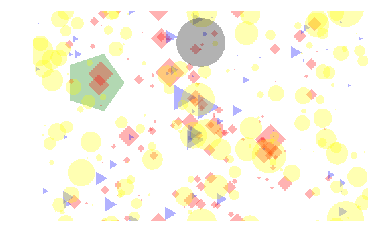

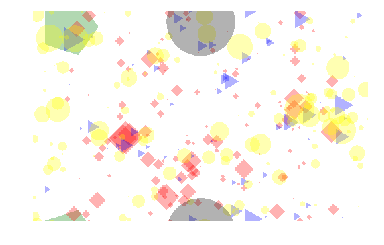

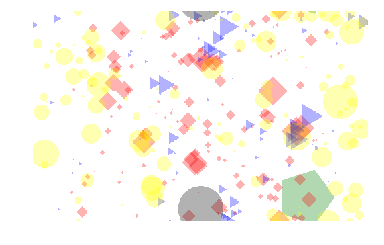

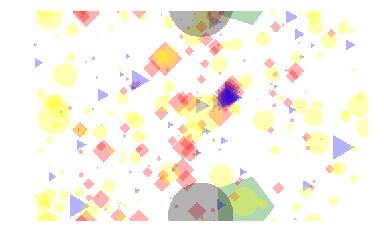

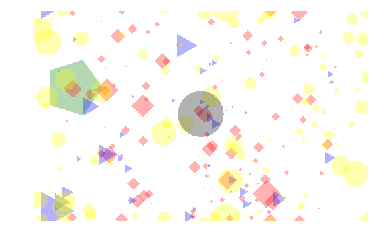

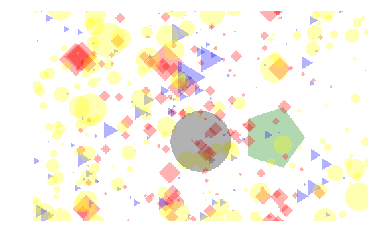

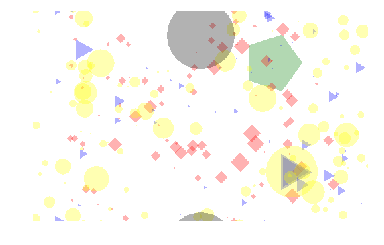

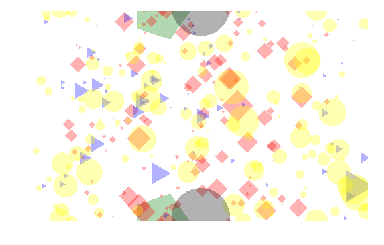

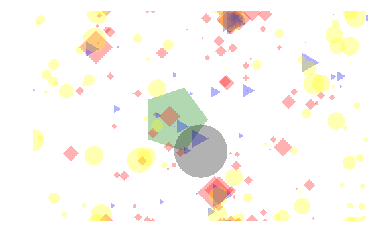

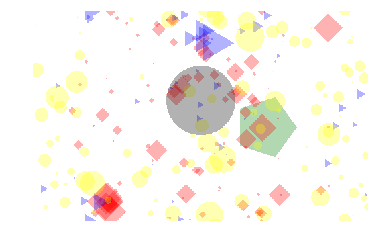

In [23]:
for x in test_images:
    img = x.image.array.reshape((500, 314, 3))
    showImage(img)

## Put images on disk

In [24]:
images.write.parquet("file:/tmp/test_step2", mode="overwrite")